
#### CNN_LSTM - ConvLSTM2D

#### Image Classification using CNN. As you all know that CNN works great on the images, but a video has an extra dimension, which is Time.

#### basically videos are nothing but a series of images over time, which makes a video classification problem, a sequence classification task. And when it comes to sequences related problem, LSTM is the first thing which comes in our mind.

### ConvLSTM is a variation of LSTM cell that performs convolution within the LSTM cell. It replaces the matrix multiplication with the convolution operation. By applying convolution it captures the spatial features from the image.

In [71]:
import keras
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
import tensorflow as tf
from keras.layers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from tensorflow.keras.utils import plot_model
 
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
## pip install keras-metrics
import keras_metrics as km
 
 
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import multilabel_confusion_matrix


In [72]:
data_dir = "C:/1-GG/CAP4/EventDetection/Dataset-LSTM/VDO/"
os.listdir(data_dir)


['Basketball', 'SoccerPenalty']

In [73]:

img_height , img_width = 64, 64
seq_len = 30
classes = ["Basketball", "SoccerPenalty"]


In [74]:

 
#  Creating frames from videos
 
def frames_extraction(video_path):
    frames_list = []
    vidObj = cv2.VideoCapture(video_path)
    # Used as counter variable 
    count = 1
 
    while count <= seq_len: 
         
        success, image = vidObj.read() 
        if success:
            image = cv2.resize(image, (img_height, img_width))
            # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
            normalized_frame = image / 255
            frames_list.append(normalized_frame)
            count += 1
            
        else:
            print("Defected frame")
            break
 
            
    return frames_list
 
def create_data(input_dir):
    X = []
    Y = []
     
    classes_list = os.listdir(input_dir)
     
    for c in classes_list:
        print(c)
        files_list = os.listdir(os.path.join(input_dir, c))
        for f in files_list:
           frames = frames_extraction(os.path.join(os.path.join(input_dir, c), f))
           if len(frames) == seq_len:
                X.append(frames)
             
                y = [0]*len(classes)
                y[classes.index(c)] = 1
                Y.append(y)
     
    X = np.asarray(X)
    Y = np.asarray(Y)
    return X, Y
 


In [75]:
X, Y = create_data(data_dir)

Basketball
SoccerPenalty


In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, shuffle=True, random_state=0)

In [77]:
X_train.shape

(220, 30, 64, 64, 3)

In [78]:
X_test.shape

(55, 30, 64, 64, 3)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_3 (ConvLSTM2D)  (None, 62, 62, 64)        154624    
_________________________________________________________________
dropout_5 (Dropout)          (None, 62, 62, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 246016)            0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               62980352  
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 514       
Total params: 63,135,490
Trainable params: 63,135,490
Non-trainable params: 0
__________________________________________

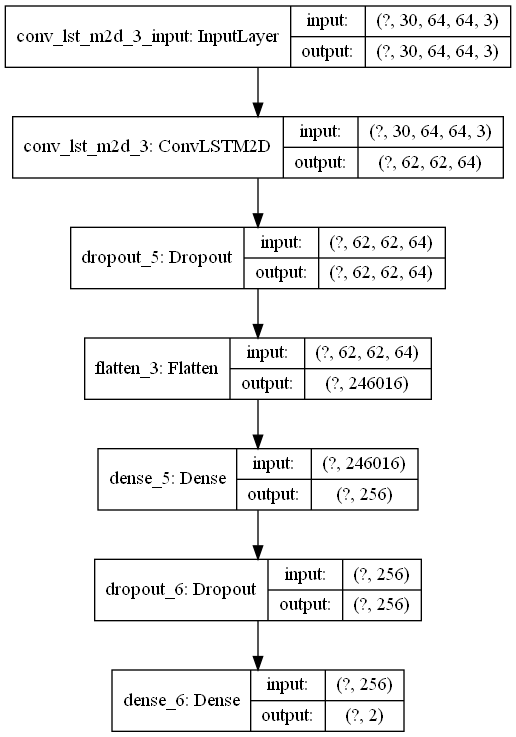

In [79]:

model = Sequential()
model.add(ConvLSTM2D(filters = 64, kernel_size = (3, 3), return_sequences = False, data_format = "channels_last", input_shape = (seq_len, img_height, img_width, 3)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.3))
#model.add(Dense(6, activation = "softmax"))
model.add(Dense(2, activation = "softmax"))
 
print(model.summary())
 
opt = keras.optimizers.SGD(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["accuracy"])
 
earlystop = EarlyStopping(patience=7)
callbacks = [earlystop]
 
## Check Model architecture
plot_model(model, to_file = 'model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [80]:
%%time
history = model.fit(x = X_train, y = y_train, epochs=10, batch_size = 4 , shuffle=True, validation_split=0.2, callbacks=callbacks)
 


Train on 176 samples, validate on 44 samples
Epoch 1/10
176/176 [==============================] - 24s 139ms/step - loss: 0.4839 - accuracy: 0.8295 - val_loss: 0.3140 - val_accuracy: 0.9091
Epoch 2/10
176/176 [==============================] - 23s 131ms/step - loss: 0.3355 - accuracy: 0.8864 - val_loss: 0.2560 - val_accuracy: 0.8636
Epoch 3/10
176/176 [==============================] - 24s 137ms/step - loss: 0.2283 - accuracy: 0.9148 - val_loss: 0.2021 - val_accuracy: 0.9545
Epoch 4/10
176/176 [==============================] - 24s 135ms/step - loss: 0.1653 - accuracy: 0.9432 - val_loss: 0.1177 - val_accuracy: 0.9318
Epoch 5/10
176/176 [==============================] - 23s 132ms/step - loss: 0.1103 - accuracy: 0.9830 - val_loss: 0.0943 - val_accuracy: 0.9545
Epoch 6/10
176/176 [==============================] - 23s 130ms/step - loss: 0.1148 - accuracy: 0.9602 - val_loss: 0.0804 - val_accuracy: 0.9545
Epoch 7/10
176/176 [==============================] - 23s 131ms/step - loss: 0.0699 -

In [81]:
import matplotlib.pyplot as plt
# Create a Matplotlib figure
plt.figure(figsize = (30, 30))

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

In [82]:
def plot_metric(metric_name_1, metric_name_2, plot_name):
  # Get Metric values using metric names as identifiers
  metric_value_1 = history.history[metric_name_1]
  metric_value_2 = history.history[metric_name_2]


  # Constructing a range object which will be used as time 
  epochs = range(len(metric_value_1))
  
  # Plotting the Graph
  plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
  plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)
  
  # Adding title to the plot
  plt.title(str(plot_name))

  # Adding legend to the plot
  plt.legend()

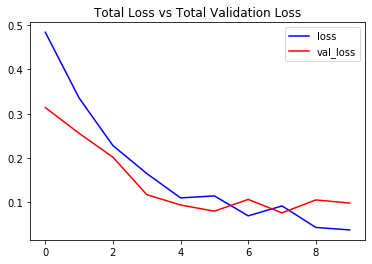

In [83]:
plot_metric('loss', 'val_loss', 'Total Loss vs Total Validation Loss')

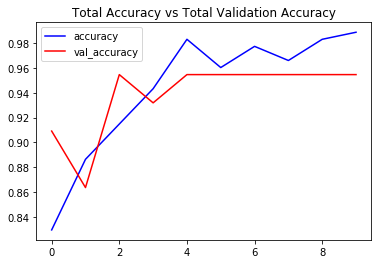

In [84]:
plot_metric('accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

In [85]:
#model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history
model_name = 'CNNLSTM_modelBP.h5'
## Where to save
modesavedFolder = "C:/1-GG/CAP4/EventDetection/Dataset-LSTM/SavedModel"

In [86]:
# Saving Model
model.save(modesavedFolder+'/'+model_name)

In [87]:
### How to readback the model from disk
from tensorflow import keras
model = keras.models.load_model(modesavedFolder+'/'+model_name)

In [88]:
%%time
with tf.device("cpu:0"):preds = model.predict(X_test,0)
preds = np.round(preds)

Wall time: 25.3 s


In [89]:
print('Round Test_labels' , preds)

Round Test_labels [[1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]]


In [90]:
from sklearn.metrics import classification_report
classification_metrics = classification_report(y_test,preds, target_names = classes)
print(classification_metrics)

               precision    recall  f1-score   support

   Basketball       0.96      1.00      0.98        23
SoccerPenalty       1.00      0.97      0.98        32

    micro avg       0.98      0.98      0.98        55
    macro avg       0.98      0.98      0.98        55
 weighted avg       0.98      0.98      0.98        55
  samples avg       0.98      0.98      0.98        55



# Test Model on Video

In [91]:
from collections import deque

Vdo_input_directory = 'C:/1-GG/CAP4/EventDetection/Dataset-LSTM/CNNLSTM_Apply_vdo/Apply_vdo'

# Getting input Video's path 
video_title = 'combined_video-2vdo'
input_video_file_path = f'{Vdo_input_directory}/{video_title}.mp4'
print(input_video_file_path)

C:/1-GG/CAP4/EventDetection/Dataset-LSTM/CNNLSTM_Apply_vdo/Apply_vdo/combined_video-2vdo.mp4


In [92]:
# Setting sthe Window Size which will be used by the Rolling Average Proces
window_size = 1

Vdo_output_directory = 'C:/1-GG/CAP4/EventDetection/Dataset-LSTM/CNNLSTM_Apply_vdo/OutPut_vdo'
# Setting up Output Video Path
output_video_file_path = f'{Vdo_output_directory}/{video_title} -Output-WSize {window_size}.mp4'

print(output_video_file_path)

C:/1-GG/CAP4/EventDetection/Dataset-LSTM/CNNLSTM_Apply_vdo/OutPut_vdo/combined_video-2vdo -Output-WSize 1.mp4


In [93]:
video_file_path = input_video_file_path

video_reader = cv2.VideoCapture(video_file_path)

if not video_reader.isOpened():
    print("Cannot open file")
else:
    print("Open successfully")
    


Open successfully


### Define Live VDO prediction function

In [94]:

 
#  Creating final output video
 
def Create_output_Video(video_path,output_file_path):
    frames_list = []
    frame_sequence = []
    original_frames = []
    vidObj = cv2.VideoCapture(video_path)
     # Getting the width and height of the video 
    original_video_width = int(vidObj.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(vidObj.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Writing the Overlayed Video Files Using the VideoWriter Object
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'), 24, (original_video_width, original_video_height))

    # Used as counter variable 
    count = 1
 
    while True: 
         
        success, image = vidObj.read() 
        if success:
            original_frames.append(image)
            normalized_frame = cv2.resize(image, (img_height, img_width))
            # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
            normalized_frame = normalized_frame / 255
            frames_list.append(normalized_frame)
            if(count % seq_len == 0):
                frame_sequence.append(frames_list)
                frame_sequence = np.array(frame_sequence)
                print(frame_sequence.shape)
                predicted_labels_probabilities = model.predict(frame_sequence, 0)
                predicted_labels_probabilities = np.round(predicted_labels_probabilities)
                predicted_label = np.argmax(predicted_labels_probabilities)
                predicted_class_name = classes[predicted_label]
                for original_frame in original_frames:
                    # Overlaying Class Name Text Ontop of the Frame
                    cv2.putText(original_frame, predicted_class_name, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
                    #cv2.putText(frame, avg_prob, (60, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)
                    #cv2.putText(original_frame, predicted_labels_probabilities, (80, 100),  cv2.FONT_HERSHEY_SIMPLEX, 1,(0, 0, 255), 2)
                    # Writing The Frame
                    video_writer.write(original_frame)
                frames_list = []
                frame_sequence = []
                original_frames = []
            count += 1
            
            
        else:
            print("Defected frame")
            break
            
    # Closing the VideoCapture and VideoWriter objects and releasing all resources held by them. 
    video_reader.release()
    video_writer.release()
 

In [95]:
%%time
# Calling the create_output_video method to start the Prediction.
Create_output_Video(input_video_file_path,output_video_file_path)
print("Predicted Video Created")

(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 64, 3)
(1, 30, 64, 